In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.models as models
import time
import os
import uuid
from itertools import chain
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import argparse
import csv
import os

from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.utils.data
import sys
from itertools import chain
import torchvision
import matplotlib.pyplot as plt
import glob
from torch.hub import load_state_dict_from_url

In [2]:
cudan = 0

In [3]:
BATCH_SIZE = 128

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='../data', 
                               train=True, 
                               transform=transform_test,
                               download=True)

test_dataset = datasets.CIFAR10(root='../data', 
                              train=False, 
                              transform=transform_test)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

Files already downloaded and verified


In [4]:
import torch
import torch.nn as nn


from torch.autograd import Variable


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, lin=0, lout=5):
        out = x
        if lin < 1 and lout > -1:
            out = self.conv1(out)
            out = self.bn1(out)
            out = F.relu(out)
        if lin < 2 and lout > 0:
            out = self.layer1(out)
        if lin < 3 and lout > 1:
            out = self.layer2(out)
        if lin < 4 and lout > 2:
            out = self.layer3(out)
        if lin < 5 and lout > 3:
            out = self.layer4(out)
        if lout > 4:
            out = F.avg_pool2d(out, 4)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
        return out


def ResNet18():
    return ResNet(PreActBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet18()
    y = net(Variable(torch.randn(1,3,32,32)))
    print(y.size())

In [5]:
net = ResNet18()

In [6]:
net.cuda()
net = torch.nn.DataParallel(net)
print(torch.cuda.device_count())
cudnn.benchmark = True
print('Using CUDA..')

2
Using CUDA..


In [7]:
net.load_state_dict(torch.load("./norm05_IATresnet18_epo_190"))


<All keys matched successfully>

In [8]:
net.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): PreActBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (shortcut): Sequential()
      )
      (1): PreActBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [14]:
test_adv = np.load("DAA_adv_blob_test_IAT_norm_100.npy",allow_pickle=True)
test_adv_tar = np.load("DAA_adv_blob_target_IAT_norm_100.npy",allow_pickle=True)



In [17]:
train_mean = []
    
for i in range(len(test_adv)):
    train_mean.append([test_adv[i], test_adv_tar[i]])
train_mean_loader = torch.utils.data.DataLoader(train_mean ,batch_size=8)

In [20]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)


def imshow(img, title = False):
    img = inv_normalize(img)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    if(title):
        plt.title("{}".format(title))
    plt.show()

In [22]:
def accu(pred,label):
    _, predicted = torch.max(pred.data, 1)
    result = (predicted == label).type(torch.float)
    return result.mean().item()

# Prediction of Adversarial Images 

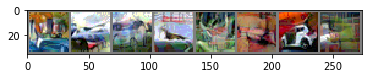

Pridicted labels
['car', 'plane', 'horse', 'bird', 'deer', 'plane', 'truck', 'bird']
True labels
['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog']


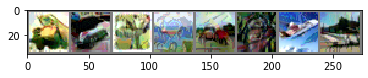

Pridicted labels
['frog', 'car', 'deer', 'plane', 'truck', 'dog', 'ship', 'plane']
True labels
['truck', 'ship', 'horse', 'ship', 'ship', 'deer', 'plane', 'car']


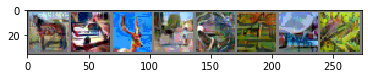

Pridicted labels
['car', 'truck', 'plane', 'truck', 'frog', 'plane', 'plane', 'frog']
True labels
['horse', 'car', 'deer', 'horse', 'deer', 'deer', 'ship', 'deer']


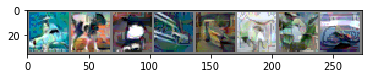

Pridicted labels
['horse', 'dog', 'car', 'car', 'bird', 'truck', 'truck', 'car']
True labels
['ship', 'horse', 'bird', 'plane', 'frog', 'ship', 'car', 'deer']


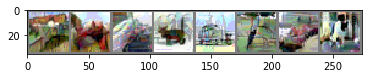

Pridicted labels
['plane', 'horse', 'truck', 'deer', 'truck', 'bird', 'ship', 'dog']
True labels
['ship', 'truck', 'horse', 'cat', 'car', 'cat', 'cat', 'cat']


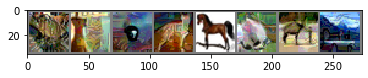

Pridicted labels
['frog', 'cat', 'bird', 'cat', 'horse', 'cat', 'deer', 'car']
True labels
['car', 'dog', 'deer', 'dog', 'horse', 'dog', 'horse', 'ship']


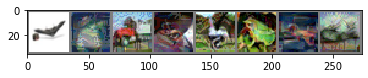

Pridicted labels
['plane', 'frog', 'horse', 'dog', 'horse', 'frog', 'car', 'deer']
True labels
['plane', 'cat', 'truck', 'deer', 'plane', 'cat', 'deer', 'truck']


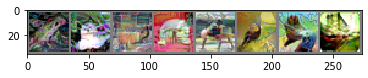

Pridicted labels
['frog', 'ship', 'deer', 'cat', 'horse', 'bird', 'frog', 'frog']
True labels
['deer', 'dog', 'frog', 'dog', 'cat', 'deer', 'bird', 'truck']


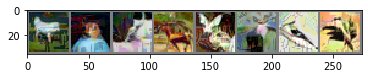

Pridicted labels
['horse', 'dog', 'horse', 'horse', 'deer', 'deer', 'bird', 'cat']
True labels
['dog', 'frog', 'dog', 'deer', 'dog', 'ship', 'ship', 'plane']


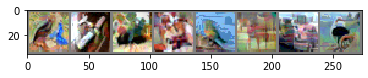

Pridicted labels
['bird', 'cat', 'bird', 'dog', 'truck', 'ship', 'truck', 'bird']
True labels
['deer', 'plane', 'cat', 'frog', 'bird', 'frog', 'cat', 'cat']


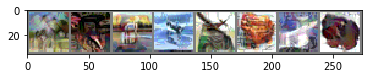

Pridicted labels
['horse', 'dog', 'ship', 'plane', 'deer', 'truck', 'plane', 'dog']
True labels
['ship', 'bird', 'deer', 'bird', 'plane', 'dog', 'ship', 'frog']


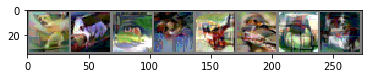

Pridicted labels
['dog', 'horse', 'ship', 'dog', 'plane', 'bird', 'horse', 'dog']
True labels
['cat', 'car', 'deer', 'ship', 'cat', 'frog', 'dog', 'cat']


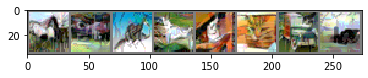

Pridicted labels
['horse', 'car', 'cat', 'dog', 'dog', 'cat', 'truck', 'bird']
True labels
['truck', 'bird', 'plane', 'horse', 'cat', 'dog', 'car', 'ship']


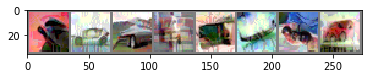

Pridicted labels
['bird', 'ship', 'car', 'dog', 'truck', 'plane', 'dog', 'car']
True labels
['cat', 'car', 'truck', 'frog', 'cat', 'ship', 'cat', 'ship']


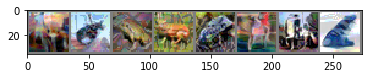

Pridicted labels
['dog', 'plane', 'frog', 'frog', 'frog', 'dog', 'truck', 'plane']
True labels
['frog', 'horse', 'deer', 'dog', 'car', 'cat', 'horse', 'frog']


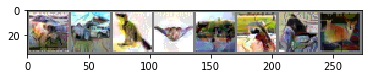

Pridicted labels
['car', 'truck', 'cat', 'bird', 'ship', 'horse', 'bird', 'cat']
True labels
['ship', 'plane', 'bird', 'plane', 'horse', 'deer', 'plane', 'frog']


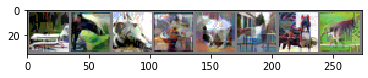

Pridicted labels
['ship', 'horse', 'plane', 'horse', 'cat', 'truck', 'horse', 'cat']
True labels
['plane', 'deer', 'ship', 'deer', 'horse', 'car', 'cat', 'bird']


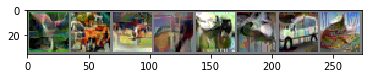

Pridicted labels
['bird', 'truck', 'horse', 'cat', 'horse', 'plane', 'truck', 'cat']
True labels
['frog', 'frog', 'deer', 'frog', 'truck', 'car', 'car', 'horse']


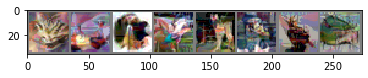

Pridicted labels
['cat', 'ship', 'dog', 'horse', 'dog', 'bird', 'ship', 'frog']
True labels
['deer', 'deer', 'cat', 'dog', 'deer', 'frog', 'bird', 'cat']


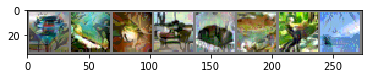

Pridicted labels
['truck', 'bird', 'frog', 'plane', 'cat', 'frog', 'bird', 'ship']
True labels
['ship', 'ship', 'bird', 'truck', 'car', 'bird', 'frog', 'plane']


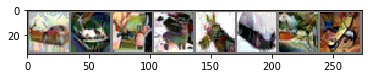

Pridicted labels
['car', 'ship', 'deer', 'dog', 'cat', 'cat', 'horse', 'frog']
True labels
['truck', 'car', 'frog', 'deer', 'horse', 'car', 'truck', 'plane']


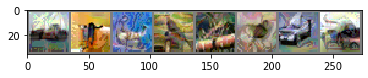

Pridicted labels
['ship', 'dog', 'deer', 'bird', 'deer', 'bird', 'car', 'plane']
True labels
['plane', 'cat', 'plane', 'frog', 'bird', 'plane', 'truck', 'ship']


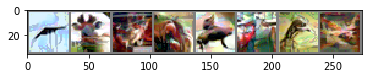

Pridicted labels
['bird', 'dog', 'dog', 'horse', 'cat', 'horse', 'bird', 'plane']
True labels
['plane', 'deer', 'frog', 'cat', 'frog', 'truck', 'cat', 'frog']


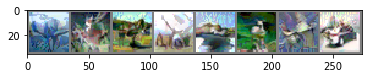

Pridicted labels
['plane', 'deer', 'plane', 'deer', 'ship', 'bird', 'plane', 'car']
True labels
['ship', 'cat', 'horse', 'ship', 'truck', 'deer', 'ship', 'truck']


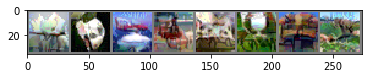

Pridicted labels
['plane', 'dog', 'ship', 'horse', 'truck', 'bird', 'truck', 'deer']
True labels
['ship', 'car', 'plane', 'bird', 'ship', 'dog', 'frog', 'horse']


In [24]:
class_ = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
correct = 0
con_matrix = np.zeros((10,10))
for batch_idxx, (data, classes) in enumerate(train_mean_loader):
    with torch.no_grad():
        data = data.cuda()
        target = classes.cuda()
        outputs = net(data.view(-1,3,32,32).float()).cuda()
        correct += accu(outputs.cuda(),target)
        _, predicted = torch.max(outputs.data, 1)
        for k in range(len(predicted)):
            con_matrix[target.cpu()[k]][predicted.cpu()[k]] += 1
        if(batch_idxx%50==0):
            _, predicted = torch.max(outputs.data, 1)

            imshow(torchvision.utils.make_grid(data.view(-1,3,32,32).cpu().detach()))
            print("Pridicted labels")
            print([class_[predicted.cpu()[i]] for i in range(len(predicted)) ])
            print("True labels")
            print([class_[target.cpu()[i]] for i in range(len(target)) ])
 
    
    
    
    

# Accuracy 

In [25]:
print('Accuracy on test images: %f %%' % (
    100 * correct / len(train_mean_loader)))

Accuracy on test images: 1.180000 %


# Accuracy on original images

In [28]:
correct = 0
for batch_idxx, (data, classes) in enumerate(test_loader):
    with torch.no_grad():
        data=data.cuda()
        classes = classes.cuda()
        outputs = net(data)
        correct += accu(outputs.cuda(),classes)
        _, predicted = torch.max(outputs.data, 1)

In [29]:
print('Accuracy on test images: %f %%' % (
    100 * correct / len(test_loader)))

Accuracy on test images: 87.668117 %
